# Importing Dependencies

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Understanding the Data

In [3]:
path = os.path.join(os.getcwd(), '/kaggle/input/breakhis-400x/BreaKHis 400X')
train_path = os.path.join(path, '/kaggle/input/breakhis-400x/BreaKHis 400X/train')
val_path = os.path.join(path, '/kaggle/input/breakhis-400x/BreaKHis 400X/test')

In [4]:
#Getting class labels
class_labels = []

for dir in os.listdir(train_path):
    class_labels.append(dir)

class_labels

['benign', 'malignant']

In [5]:
number_of_images_per_category = {}

for cat in os.listdir(train_path):
    number_of_images_per_category[cat] = len(os.listdir(os.path.join(train_path, cat)))

number_of_images_per_category    

{'benign': 371, 'malignant': 777}

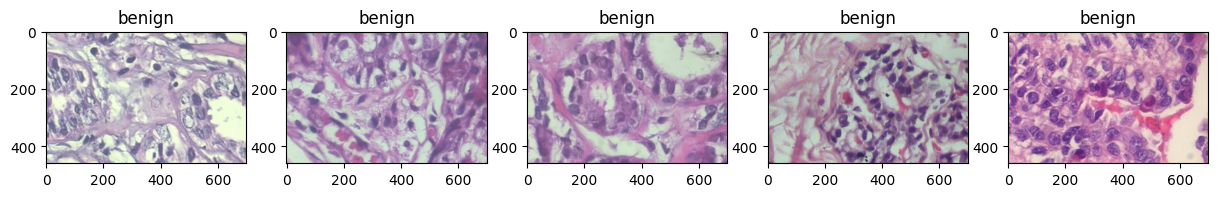

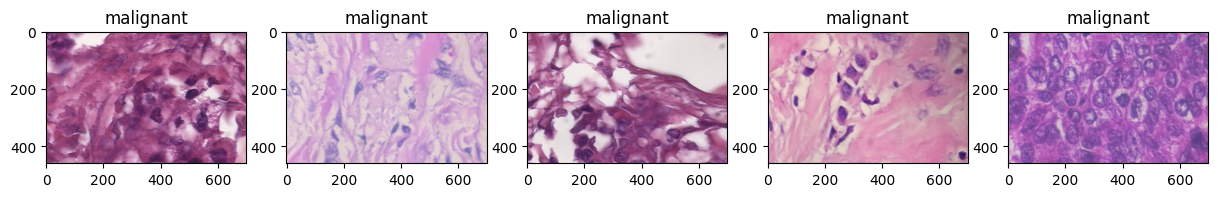

In [6]:
def plot_images(folder_path, label):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    [axs[i].imshow(plt.imread(os.path.join(folder_path, file))) for i, file in enumerate(os.listdir(folder_path)[:5])]
    [axs[i].set_title(label) for i in range(5)]
    plt.show()

benign_path = "/kaggle/input/breakhis-400x/BreaKHis 400X/train/benign"
plot_images(benign_path, "benign")
malignant_path = "/kaggle/input/breakhis-400x/BreaKHis 400X/train/malignant"
plot_images(malignant_path, "malignant")

# Loading Data and Augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
img_size = 224
batch_size = 32

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [10]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
)

val_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


In [12]:
# Get class indices and names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Iterate over classes and count number of images
for class_name in class_names:
    class_dir = os.path.join(train_generator.directory, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")

benign: 371 images
malignant: 777 images


In [13]:
len(train_generator)

36

# Model

In [14]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## RESNET152V2

In [15]:
resnet152v2_base = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

234545216/234545216 [==============================] - 1s 0us/step


In [16]:
# resnet152v2_base.summary()

In [17]:
resnet152v2_model = Sequential()
resnet152v2_model.add(resnet152v2_base)
resnet152v2_model.add(Flatten())
resnet152v2_model.add(BatchNormalization())
resnet152v2_model.add(Dense(1024, activation='relu'))
resnet152v2_model.add(Dropout(0.4))
resnet152v2_model.add(Dense(512, activation='relu'))
resnet152v2_model.add(Dropout(0.4))
resnet152v2_model.add(Dense(256, activation='relu'))
resnet152v2_model.add(Dropout(0.4))
resnet152v2_model.add(BatchNormalization())
resnet152v2_model.add(Dense(1, activation='sigmoid'))

In [18]:
resnet152v2_base.trainable = False

In [19]:
resnet152v2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet152v2_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [21]:
resnet152v2_history = resnet152v2_model.fit(train_generator, epochs=70, validation_data=val_generator)

Epoch 1/70
36/36 [==============================] - 84s 2s/step - loss: 0.7059 - accuracy: 0.6185 - precision: 0.7927 - recall: 0.5907 - auc: 0.6919 - val_loss: 0.7352 - val_accuracy: 0.6495 - val_precision: 0.9009 - val_recall: 0.5420 - val_auc: 0.8101
Epoch 2/70
36/36 [==============================] - 37s 1s/step - loss: 0.5887 - accuracy: 0.7125 - precision: 0.8520 - recall: 0.6963 - auc: 0.7976 - val_loss: 0.5409 - val_accuracy: 0.7633 - val_precision: 0.9082 - val_recall: 0.7236 - val_auc: 0.8638
Epoch 3/70
36/36 [==============================] - 38s 1s/step - loss: 0.5353 - accuracy: 0.7343 - precision: 0.8565 - recall: 0.7297 - auc: 0.8300 - val_loss: 0.4731 - val_accuracy: 0.7982 - val_precision: 0.8985 - val_recall: 0.7913 - val_auc: 0.8881
Epoch 4/70
36/36 [==============================] - 38s 1s/step - loss: 0.5243 - accuracy: 0.7544 - precision: 0.8678 - recall: 0.7516 - auc: 0.8335 - val_loss: 0.4228 - val_accuracy: 0.8459 - val_precision: 0.8926 - val_recall: 0.8780 - 

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


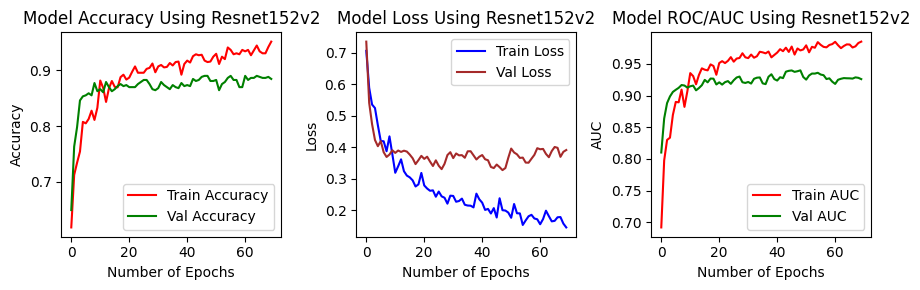

In [22]:
print(resnet152v2_history.history.keys())

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].plot(resnet152v2_history.history['accuracy'], color='red')
axs[0].plot(resnet152v2_history.history['val_accuracy'], color='green')
axs[0].set_title('Model Accuracy Using Resnet152v2')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Epochs')
axs[0].legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')

axs[1].plot(resnet152v2_history.history['loss'], color='blue')
axs[1].plot(resnet152v2_history.history['val_loss'], color='brown')
axs[1].set_title('Model Loss Using Resnet152v2')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Number of Epochs')
axs[1].legend(['Train Loss', 'Val Loss'], loc='upper right')

axs[2].plot(resnet152v2_history.history['auc'], color='red')
axs[2].plot(resnet152v2_history.history['val_auc'], color='green')
axs[2].set_title('Model ROC/AUC Using Resnet152v2')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Number of Epochs')
axs[2].legend(['Train AUC', 'Val AUC'], loc='lower right')

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = resnet152v2_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix Using Resnet152v2:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report Using Resnet152v2:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy Using Resnet152v2:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score Using Resnet152v2:", f1)

Confusion matrix Using Resnet152v2:
 [[139  37]
 [ 26 343]]
Classification report Using Resnet152v2:
               precision    recall  f1-score   support

         0.0       0.84      0.79      0.82       176
         1.0       0.90      0.93      0.92       369

    accuracy                           0.88       545
   macro avg       0.87      0.86      0.87       545
weighted avg       0.88      0.88      0.88       545

Accuracy Using Resnet152v2: 0.8844036697247707
F1-score Using Resnet152v2: 0.9158878504672897


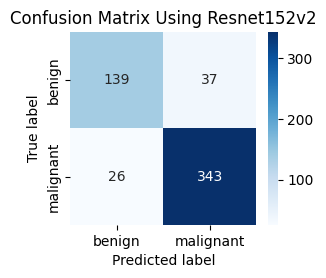

In [24]:
# Plot the confusion matrix
plt.figure(figsize=(3,2.5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion Matrix Using Resnet152v2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## DENSENET201

In [25]:
densenet201_base = tf.keras.applications.DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

74836368/74836368 [==============================] - 1s 0us/step


In [26]:
densenet201_model = Sequential()
densenet201_model.add(densenet201_base)
densenet201_model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
densenet201_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
densenet201_model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
densenet201_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
densenet201_model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
densenet201_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
densenet201_model.add(Flatten())
densenet201_model.add(BatchNormalization())
densenet201_model.add(Dense(1024, activation='relu'))
densenet201_model.add(Dropout(0.4))
densenet201_model.add(Dense(256, activation='relu'))
densenet201_model.add(layers.Dropout(0.4))
densenet201_model.add(layers.BatchNormalization())
densenet201_model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
densenet201_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 64)         

In [28]:
densenet201_base.trainable = False

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
densenet201_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [30]:
densenet201_history = densenet201_model.fit(train_generator, epochs=70, validation_data=val_generator)

Epoch 1/70
36/36 [==============================] - 61s 1s/step - loss: 0.8385 - accuracy: 0.5340 - precision_1: 0.7161 - recall_1: 0.5161 - auc_1: 0.5515 - val_loss: 0.6411 - val_accuracy: 0.6752 - val_precision_1: 0.6771 - val_recall_1: 0.9946 - val_auc_1: 0.6518
Epoch 2/70
36/36 [==============================] - 36s 1s/step - loss: 0.7551 - accuracy: 0.5949 - precision_1: 0.7662 - recall_1: 0.5779 - auc_1: 0.6436 - val_loss: 0.6236 - val_accuracy: 0.7009 - val_precision_1: 0.7052 - val_recall_1: 0.9593 - val_auc_1: 0.7210
Epoch 3/70
36/36 [==============================] - 36s 998ms/step - loss: 0.6700 - accuracy: 0.6603 - precision_1: 0.8067 - recall_1: 0.6551 - auc_1: 0.7283 - val_loss: 0.5600 - val_accuracy: 0.7450 - val_precision_1: 0.7650 - val_recall_1: 0.8997 - val_auc_1: 0.7967
Epoch 4/70
36/36 [==============================] - 38s 1s/step - loss: 0.6056 - accuracy: 0.7195 - precision_1: 0.8663 - recall_1: 0.6924 - auc_1: 0.7946 - val_loss: 0.5405 - val_accuracy: 0.7835 - 

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_auc_1'])


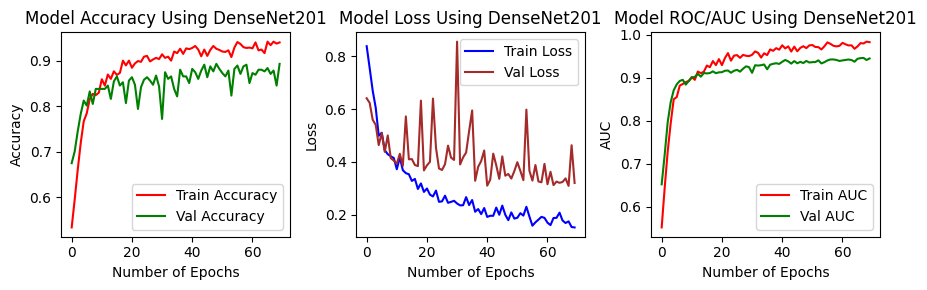

In [31]:
print(densenet201_history.history.keys())

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].plot(densenet201_history.history['accuracy'], color='red')
axs[0].plot(densenet201_history.history['val_accuracy'], color='green')
axs[0].set_title('Model Accuracy Using DenseNet201')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Epochs')
axs[0].legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')

axs[1].plot(densenet201_history.history['loss'], color='blue')
axs[1].plot(densenet201_history.history['val_loss'], color='brown')
axs[1].set_title('Model Loss Using DenseNet201')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Number of Epochs')
axs[1].legend(['Train Loss', 'Val Loss'], loc='upper right')

axs[2].plot(densenet201_history.history['auc_1'], color='red')
axs[2].plot(densenet201_history.history['val_auc_1'], color='green')
axs[2].set_title('Model ROC/AUC Using DenseNet201')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Number of Epochs')
axs[2].legend(['Train AUC', 'Val AUC'], loc='lower right')

plt.tight_layout()
plt.show()

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = densenet201_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix Using DenseNet201:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report Using DenseNet201:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy Using DenseNet201:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score Using DenseNet201:", f1)

Confusion matrix Using DenseNet201:
 [[143  33]
 [ 25 344]]
Classification report Using DenseNet201:
               precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       176
         1.0       0.91      0.93      0.92       369

    accuracy                           0.89       545
   macro avg       0.88      0.87      0.88       545
weighted avg       0.89      0.89      0.89       545

Accuracy Using DenseNet201: 0.8935779816513761
F1-score Using DenseNet201: 0.9222520107238606


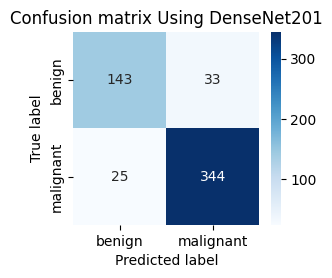

In [33]:

# Plot the confusion matrix
plt.figure(figsize=(3,2.5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix Using DenseNet201')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## VGG16

In [34]:
vgg16_base = tf.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [35]:
    vgg_model = Sequential()
    vgg_model.add(vgg16_base)
    vgg_model.add(Flatten())
    vgg_model.add(BatchNormalization())
    vgg_model.add(Dense(1024, activation = 'relu'))
    vgg_model.add(Dropout(0.3))
    vgg_model.add(Dense(256, activation = 'relu'))
    vgg_model.add(Dropout(0.3))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Dense(1, activation = 'sigmoid'))

In [36]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                      

In [37]:
vgg16_base.trainable = False

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [39]:
vgg_history = vgg_model.fit(train_generator, epochs = 70, validation_data = val_generator)

Epoch 1/70
36/36 [==============================] - 52s 1s/step - loss: 0.7129 - accuracy: 0.6385 - precision_2: 0.8078 - recall_2: 0.6113 - auc_2: 0.7320 - val_loss: 0.6669 - val_accuracy: 0.5541 - val_precision_2: 0.9375 - val_recall_2: 0.3659 - val_auc_2: 0.8374
Epoch 2/70
36/36 [==============================] - 35s 988ms/step - loss: 0.5633 - accuracy: 0.7430 - precision_2: 0.8862 - recall_2: 0.7117 - auc_2: 0.8408 - val_loss: 0.5741 - val_accuracy: 0.7193 - val_precision_2: 0.9655 - val_recall_2: 0.6070 - val_auc_2: 0.8838
Epoch 3/70
36/36 [==============================] - 37s 1s/step - loss: 0.5047 - accuracy: 0.7596 - precision_2: 0.8860 - recall_2: 0.7400 - auc_2: 0.8640 - val_loss: 0.4788 - val_accuracy: 0.8055 - val_precision_2: 0.9256 - val_recall_2: 0.7751 - val_auc_2: 0.8998
Epoch 4/70
36/36 [==============================] - 36s 993ms/step - loss: 0.4614 - accuracy: 0.7927 - precision_2: 0.9090 - recall_2: 0.7709 - auc_2: 0.8908 - val_loss: 0.3889 - val_accuracy: 0.8495

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'auc_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'val_auc_2'])


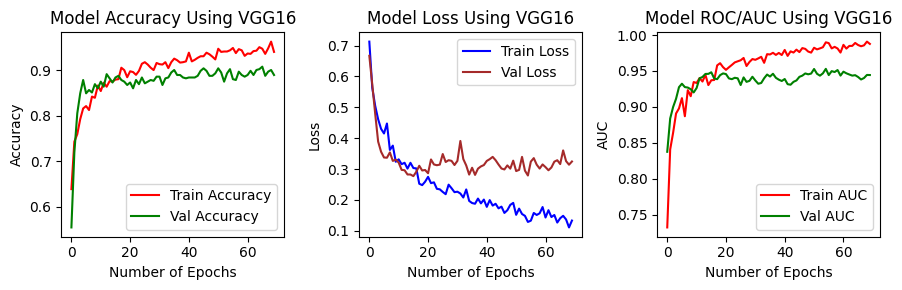

In [40]:
print(vgg_history.history.keys())

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].plot(vgg_history.history['accuracy'], color='red')
axs[0].plot(vgg_history.history['val_accuracy'], color='green')
axs[0].set_title('Model Accuracy Using VGG16')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Epochs')
axs[0].legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')

axs[1].plot(vgg_history.history['loss'], color='blue')
axs[1].plot(vgg_history.history['val_loss'], color='brown')
axs[1].set_title('Model Loss Using VGG16')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Number of Epochs')
axs[1].legend(['Train Loss', 'Val Loss'], loc='upper right')

axs[2].plot(vgg_history.history['auc_2'], color='red')
axs[2].plot(vgg_history.history['val_auc_2'], color='green')
axs[2].set_title('Model ROC/AUC Using VGG16')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Number of Epochs')
axs[2].legend(['Train AUC', 'Val AUC'], loc='lower right')

plt.tight_layout()
plt.show()

In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = vgg_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix Using VGG16:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report Using VGG16:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy Using VGG16:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score Using VGG16:", f1)

Confusion matrix Using VGG16:
 [[134  42]
 [ 18 351]]
Classification report Using VGG16:
               precision    recall  f1-score   support

         0.0       0.88      0.76      0.82       176
         1.0       0.89      0.95      0.92       369

    accuracy                           0.89       545
   macro avg       0.89      0.86      0.87       545
weighted avg       0.89      0.89      0.89       545

Accuracy Using VGG16: 0.8899082568807339
F1-score Using VGG16: 0.9212598425196851


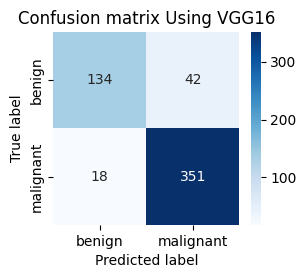

In [42]:
# Plot the confusion matrix
plt.figure(figsize=(3,2.5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix Using VGG16')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Xception

In [43]:
xception_base = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3)
)

83683744/83683744 [==============================] - 0s 0us/step


In [44]:
xception_model = Sequential()
xception_model.add(xception_base)
xception_model.add(Flatten())
xception_model.add(BatchNormalization())
xception_model.add(Dense(1024, activation = 'relu'))
xception_model.add(Dropout(0.4))
xception_model.add(Dense(512, activation = 'relu'))
xception_model.add(Dropout(0.4))
xception_model.add(Dense(256, activation = 'relu'))
xception_model.add(Dropout(0.4))
xception_model.add(BatchNormalization())
xception_model.add(Dense(1, activation = 'sigmoid'))

In [45]:
xception_base.trainable = False

In [46]:
xception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_10 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                      

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
xception_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [48]:
xception_history = xception_model.fit(train_generator, epochs = 70, validation_data = val_generator)

Epoch 1/70
36/36 [==============================] - 45s 1s/step - loss: 0.7706 - accuracy: 0.6037 - precision_3: 0.7710 - recall_3: 0.5894 - auc_3: 0.6479 - val_loss: 0.5287 - val_accuracy: 0.7358 - val_precision_3: 0.7419 - val_recall_3: 0.9350 - val_auc_3: 0.7810
Epoch 2/70
36/36 [==============================] - 36s 1s/step - loss: 0.7135 - accuracy: 0.6446 - precision_3: 0.8020 - recall_3: 0.6306 - auc_3: 0.6967 - val_loss: 0.5065 - val_accuracy: 0.7596 - val_precision_3: 0.7767 - val_recall_3: 0.9051 - val_auc_3: 0.8089
Epoch 3/70
36/36 [==============================] - 36s 1s/step - loss: 0.6905 - accuracy: 0.6333 - precision_3: 0.7843 - recall_3: 0.6319 - auc_3: 0.7028 - val_loss: 0.5113 - val_accuracy: 0.7670 - val_precision_3: 0.8343 - val_recall_3: 0.8184 - val_auc_3: 0.8461
Epoch 4/70
36/36 [==============================] - 36s 1s/step - loss: 0.6176 - accuracy: 0.6934 - precision_3: 0.8274 - recall_3: 0.6911 - auc_3: 0.7621 - val_loss: 0.4828 - val_accuracy: 0.8055 - val

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'auc_3', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3', 'val_auc_3'])


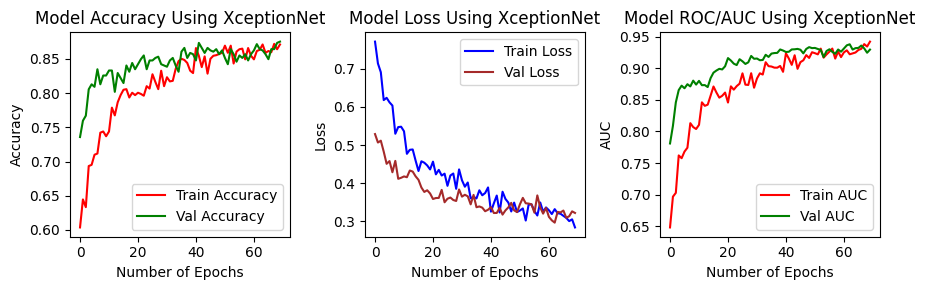

In [49]:
print(xception_history.history.keys())

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].plot(xception_history.history['accuracy'], color='red')
axs[0].plot(xception_history.history['val_accuracy'], color='green')
axs[0].set_title('Model Accuracy Using XceptionNet')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Epochs')
axs[0].legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')

axs[1].plot(xception_history.history['loss'], color='blue')
axs[1].plot(xception_history.history['val_loss'], color='brown')
axs[1].set_title('Model Loss Using XceptionNet')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Number of Epochs')
axs[1].legend(['Train Loss', 'Val Loss'], loc='upper right')

axs[2].plot(xception_history.history['auc_3'], color='red')
axs[2].plot(xception_history.history['val_auc_3'], color='green')
axs[2].set_title('Model ROC/AUC Using XceptionNet')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Number of Epochs')
axs[2].legend(['Train AUC', 'Val AUC'], loc='lower right')

plt.tight_layout()
plt.show()

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = xception_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix Using XceptionNet:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report Using XceptionNet:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy Using XceptionNet:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score Using XceptionNet:", f1)

Confusion matrix Using XceptionNet:
 [[127  49]
 [ 19 350]]
Classification report Using XceptionNet:
               precision    recall  f1-score   support

         0.0       0.87      0.72      0.79       176
         1.0       0.88      0.95      0.91       369

    accuracy                           0.88       545
   macro avg       0.87      0.84      0.85       545
weighted avg       0.87      0.88      0.87       545

Accuracy Using XceptionNet: 0.8752293577981651
F1-score Using XceptionNet: 0.9114583333333333


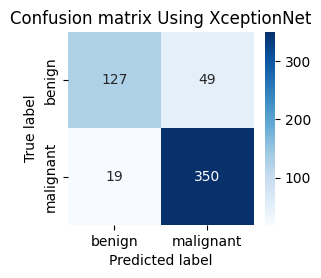

In [51]:
# Plot the confusion matrix
plt.figure(figsize=(3,2.5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix Using XceptionNet')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## InceptionResNetV2

In [52]:
InceptionResNetV2_base = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

219055592/219055592 [==============================] - 2s 0us/step


In [53]:
InceptionResNetV2_model = Sequential()
InceptionResNetV2_model.add(InceptionResNetV2_base)
InceptionResNetV2_model.add(Flatten())
InceptionResNetV2_model.add(BatchNormalization())
InceptionResNetV2_model.add(Dense(1024, activation='relu'))
InceptionResNetV2_model.add(Dropout(0.4))
InceptionResNetV2_model.add(Dense(512, activation='relu'))
InceptionResNetV2_model.add(Dropout(0.4))
InceptionResNetV2_model.add(Dense(256, activation='relu'))
InceptionResNetV2_model.add(Dropout(0.4))
InceptionResNetV2_model.add(BatchNormalization())
InceptionResNetV2_model.add(Dense(1, activation='sigmoid'))

In [54]:
InceptionResNetV2_base.trainable = False

In [55]:
InceptionResNetV2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 38400)             0         
                                                                 
 batch_normalization_215 (Ba  (None, 38400)            153600    
 tchNormalization)                                               
                                                                 
 dense_14 (Dense)            (None, 1024)              39322624  
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)              

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
InceptionResNetV2_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [57]:
InceptionResNetV2_history = InceptionResNetV2_model.fit(train_generator, epochs = 70, validation_data = val_generator)

Epoch 1/70
36/36 [==============================] - 76s 2s/step - loss: 0.7985 - accuracy: 0.5793 - precision_4: 0.7534 - recall_4: 0.5624 - auc_4: 0.6296 - val_loss: 0.5808 - val_accuracy: 0.6917 - val_precision_4: 0.8361 - val_recall_4: 0.6775 - val_auc_4: 0.7777
Epoch 2/70
36/36 [==============================] - 48s 1s/step - loss: 0.7263 - accuracy: 0.6159 - precision_4: 0.7838 - recall_4: 0.5972 - auc_4: 0.6819 - val_loss: 0.4937 - val_accuracy: 0.7670 - val_precision_4: 0.8201 - val_recall_4: 0.8401 - val_auc_4: 0.8166
Epoch 3/70
36/36 [==============================] - 48s 1s/step - loss: 0.6393 - accuracy: 0.6786 - precision_4: 0.8322 - recall_4: 0.6577 - auc_4: 0.7536 - val_loss: 0.4851 - val_accuracy: 0.7761 - val_precision_4: 0.8384 - val_recall_4: 0.8293 - val_auc_4: 0.8323
Epoch 4/70
36/36 [==============================] - 48s 1s/step - loss: 0.5992 - accuracy: 0.7117 - precision_4: 0.8441 - recall_4: 0.7040 - auc_4: 0.7784 - val_loss: 0.4814 - val_accuracy: 0.7872 - val

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'auc_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4', 'val_auc_4'])


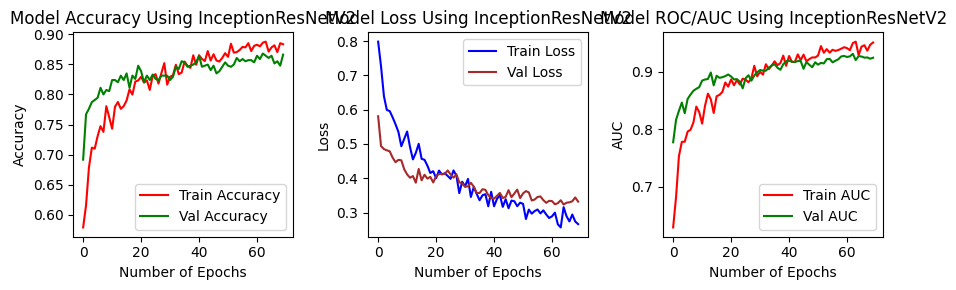

In [58]:
print(InceptionResNetV2_history.history.keys())

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].plot(InceptionResNetV2_history.history['accuracy'], color='red')
axs[0].plot(InceptionResNetV2_history.history['val_accuracy'], color='green')
axs[0].set_title('Model Accuracy Using InceptionResNetV2')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Epochs')
axs[0].legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')

axs[1].plot(InceptionResNetV2_history.history['loss'], color='blue')
axs[1].plot(InceptionResNetV2_history.history['val_loss'], color='brown')
axs[1].set_title('Model Loss Using InceptionResNetV2')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Number of Epochs')
axs[1].legend(['Train Loss', 'Val Loss'], loc='upper right')

axs[2].plot(InceptionResNetV2_history.history['auc_4'], color='red')
axs[2].plot(InceptionResNetV2_history.history['val_auc_4'], color='green')
axs[2].set_title('Model ROC/AUC Using InceptionResNetV2')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Number of Epochs')
axs[2].legend(['Train AUC', 'Val AUC'], loc='lower right')

plt.tight_layout()
plt.show()

In [59]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = InceptionResNetV2_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix Using InceptionResNetV2:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report Using InceptionResNetV2:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy Using InceptionResNetV2:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score Using InceptionResNetV2:", f1)

Confusion matrix Using InceptionResNetV2:
 [[128  48]
 [ 25 344]]
Classification report Using InceptionResNetV2:
               precision    recall  f1-score   support

         0.0       0.84      0.73      0.78       176
         1.0       0.88      0.93      0.90       369

    accuracy                           0.87       545
   macro avg       0.86      0.83      0.84       545
weighted avg       0.86      0.87      0.86       545

Accuracy Using InceptionResNetV2: 0.8660550458715597
F1-score Using InceptionResNetV2: 0.9040735873850196


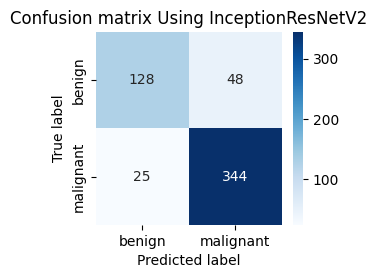

In [60]:
# Plot the confusion matrix
plt.figure(figsize=(3,2.5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix Using InceptionResNetV2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

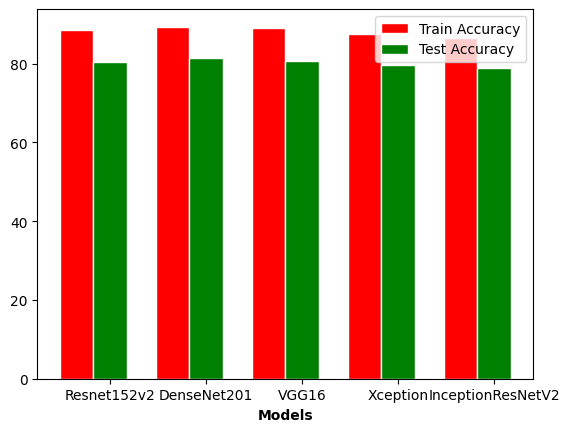

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their accuracies
models = ['Resnet152v2', 'DenseNet201', 'VGG16', 'Xception', 'InceptionResNetV2']
train_acc = [88.44, 89.36, 88.99, 87.52, 86.61]
test_acc = [80.37, 81.47, 80.73, 79.63, 78.90]

# Set the bar width
barWidth = 0.35
 
# Set the position of the bars on the x-axis
r1 = np.arange(len(train_acc))
r2 = [x + barWidth for x in r1]
 
# Create the bar plot
plt.bar(r1, train_acc, color='r', width=barWidth, edgecolor='white', label='Train Accuracy')
plt.bar(r2, test_acc, color='g', width=barWidth, edgecolor='white', label='Test Accuracy')
 
# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train_acc))], models)
 
# Add a legend and show the plot
plt.legend()
plt.show()